<a href="https://colab.research.google.com/github/Sanjaykumar13055/CREDIT-CARD-FRAUD-DETECTION/blob/main/CREDIT_CARD_FRAUD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240717%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240717T092216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dabcc009b3c338efa40503d19516828e49de47d42416427baa1c3e66b0b42d2507d3f869f75f9c3370051aa09f2a11890e259e2fa0577316eb365d0795ebb21ee6012a04b0164641ce70b552701af91d652d2223a56f6c7da2fbe16dc9b06bb2ee3a737b0b9d064bea22011fd62849babed196d63e2367b934a4d63bb828f3538afa2cbe056bed383dc9d2856c8d4ce5479d9b81b52d7401fd0e8f8a28e7521d66a9f51c035e9892ec69d54a2bfade4fb79d669c19cb568e9c13992e6c10dfa62a3d0c71449671aa66bc967ebb123bf202ef0a7d8f16fc7c1e34f73bddf1c7044f38d747f34b9a808cde6d83f20337b7dfd0b40e2f73a45a4539dc5e1990eab7d'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')),
  intern=TRUE)

system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')),
  intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))


In [ ]:
library(dplyr)
library(ranger) # for faster implementation of random forests
library(caret)
library(caTools)
library(data.table)
library(ggplot2)
library(corrplot)
library(Rtsne)
library(ROSE)
library(pROC)
library(rpart)
library(rpart.plot)
library(xgboost)

In [ ]:
dataset <- setDT(read.csv("/kaggle/input/creditcardfraud/creditcard.csv"))

In [ ]:
# Explore dataset
head(dataset)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [ ]:
tail(dataset)


Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
172785,0.1203164,0.93100513,-0.5460121,-0.7450968,1.13031398,-0.2359732,0.8127221,0.1150929,-0.2040635,⋯,-0.3142046,-0.8085204,0.05034266,0.102799590,-0.4358701,0.1240789,0.217939865,0.06880333,2.69,0
172786,-11.8811179,10.07178497,-9.8347835,-2.0666557,-5.36447278,-2.6068373,-4.9182154,7.3053340,1.9144283,⋯,0.2134541,0.1118637,1.01447990,-0.509348453,1.4368069,0.2500343,0.943651172,0.82373096,0.77,0
172787,-0.7327887,-0.05508049,2.0350297,-0.7385886,0.86822940,1.0584153,0.0243297,0.2948687,0.5848000,⋯,0.2142053,0.9243836,0.01246304,-1.016225669,-0.6066240,-0.3952551,0.068472470,-0.05352739,24.79,0
172788,1.9195650,-0.30125385,-3.2496398,-0.5578281,2.63051512,3.0312601,-0.2968265,0.7084172,0.4324540,⋯,0.2320450,0.5782290,-0.03750086,0.640133881,0.2657455,-0.0873706,0.004454772,-0.02656083,67.88,0
172788,-0.2404400,0.53048251,0.7025102,0.6897992,-0.37796113,0.6237077,-0.6861800,0.6791455,0.3920867,⋯,0.2652449,0.8000487,-0.16329794,0.123205244,-0.5691589,0.5466685,0.108820735,0.10453282,10.00,0
172792,-0.5334125,-0.18973334,0.7033374,-0.5062712,-0.01254568,-0.6496167,1.5770063,-0.4146504,0.4861795,⋯,0.2610573,0.6430784,0.37677701,0.008797379,-0.4736487,-0.8182671,-0.002415309,0.01364891,217.00,0


In [ ]:
table(dataset$Class)


     0      1 
284315    492 

In [ ]:
names(dataset)

[1] "Time"   "V1"     "V2"     "V3"     "V4"     "V5"     "V6"     "V7"    
 [9] "V8"     "V9"     "V10"    "V11"    "V12"    "V13"    "V14"    "V15"   
[17] "V16"    "V17"    "V18"    "V19"    "V20"    "V21"    "V22"    "V23"   
[25] "V24"    "V25"    "V26"    "V27"    "V28"    "Amount" "Class"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     5.60    22.00    88.35    77.17 25691.16 

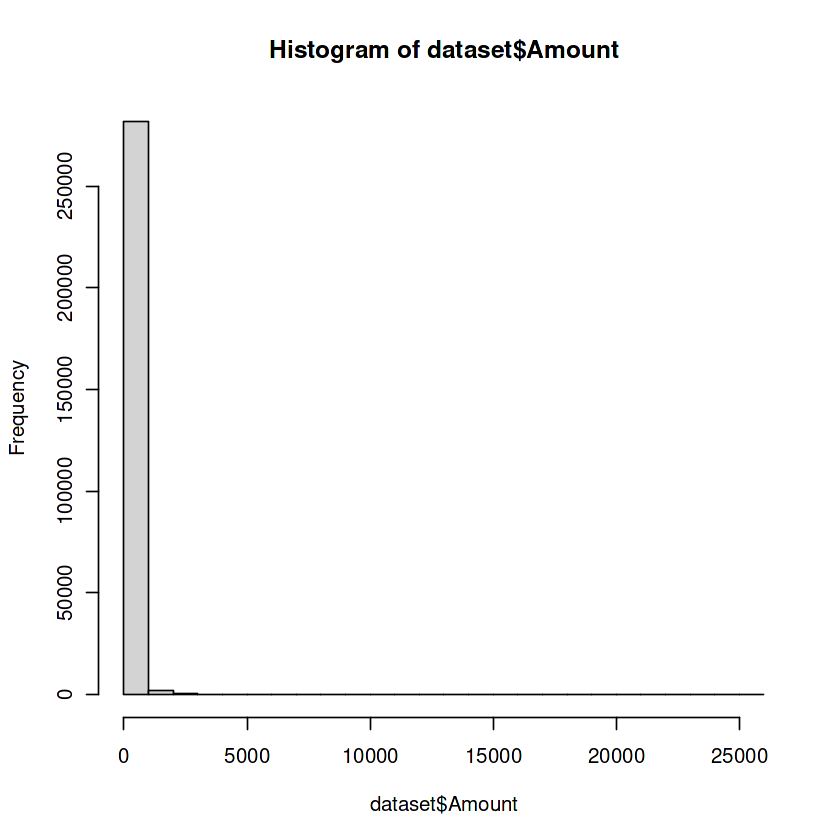

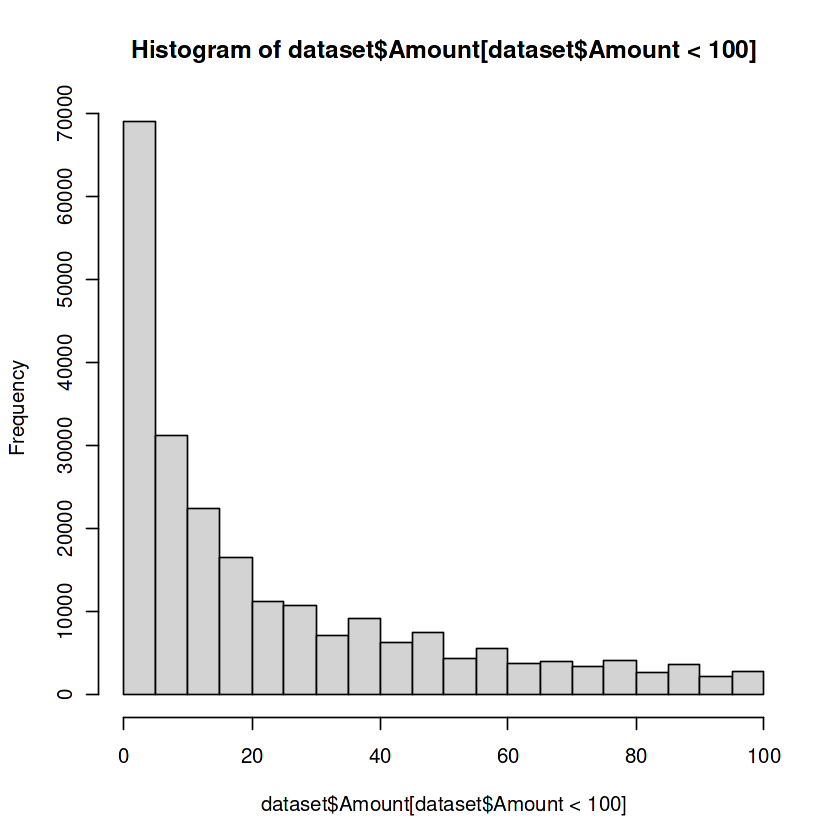

In [ ]:
# Summary of amount and histogram
summary(dataset$Amount)
hist(dataset$Amount)
hist(dataset$Amount[dataset$Amount < 100])

In [ ]:
# Variance and standard deviation of amount column
var(dataset$Amount)
sd(dataset$Amount)

[1] 62560.07

[1] 250.1201

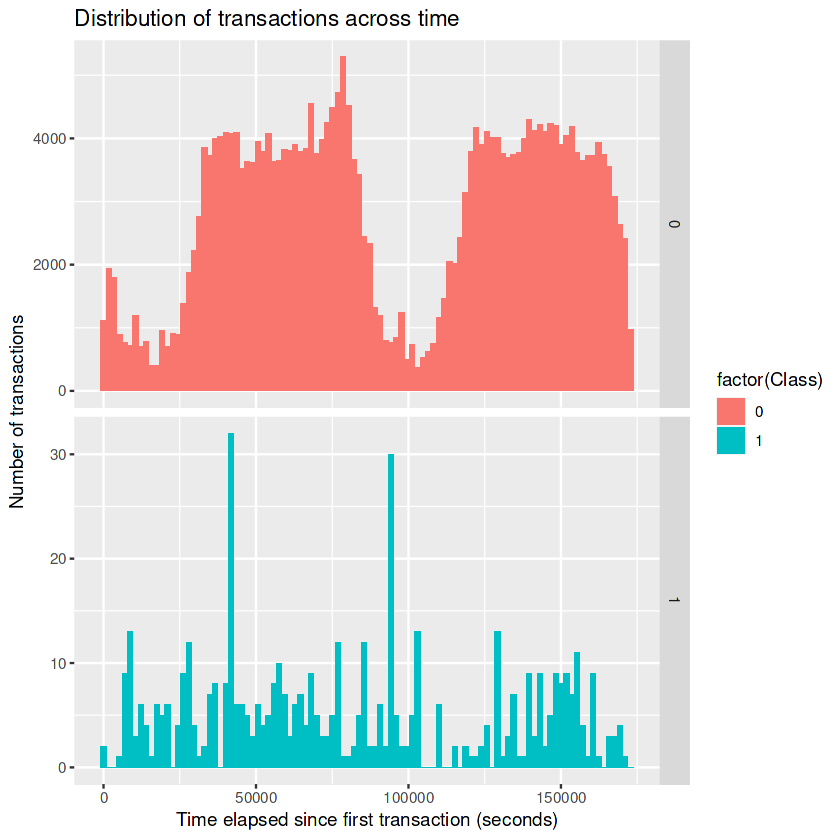

In [ ]:
# Distribution of transactions across time
dataset %>%
  ggplot(aes(x = Time, fill = factor(Class))) +
  geom_histogram(bins = 100) +
  labs(x = "Time elapsed since first transaction (seconds)",
       y = "Number of transactions",
       title = "Distribution of transactions across time") +
  facet_grid(Class ~ ., scales = 'free_y') +
  theme()

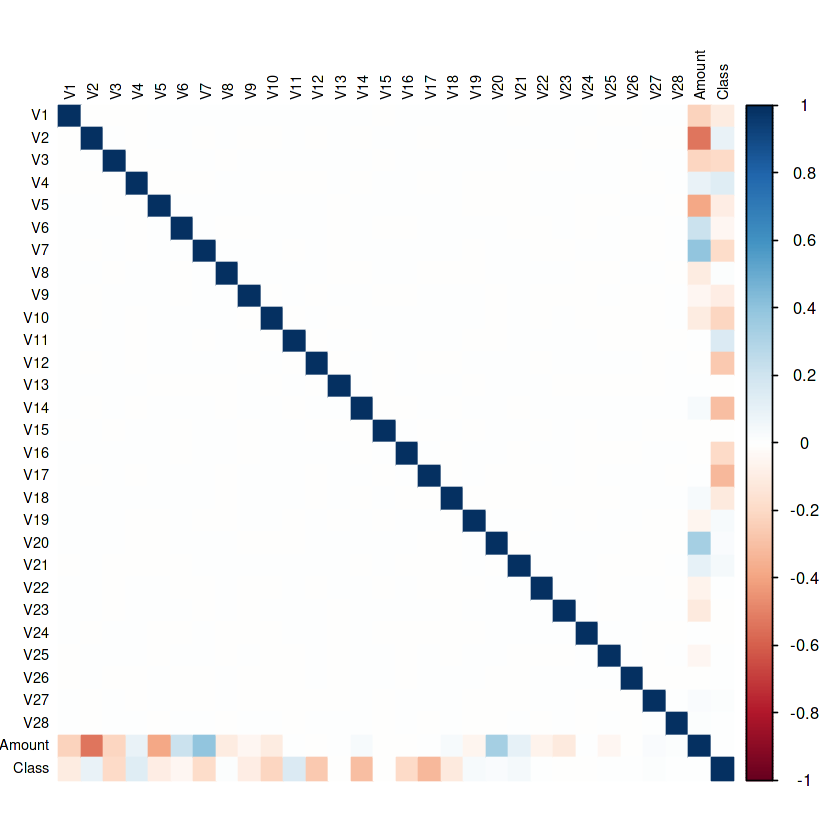

In [ ]:
# Correlation of anonymous variables with amount and class
correlation <- cor(dataset[, -1], method = "pearson")
corrplot(correlation, number.cex = 1, method = "color", type = "full", tl.cex = 0.7, tl.col = "black")

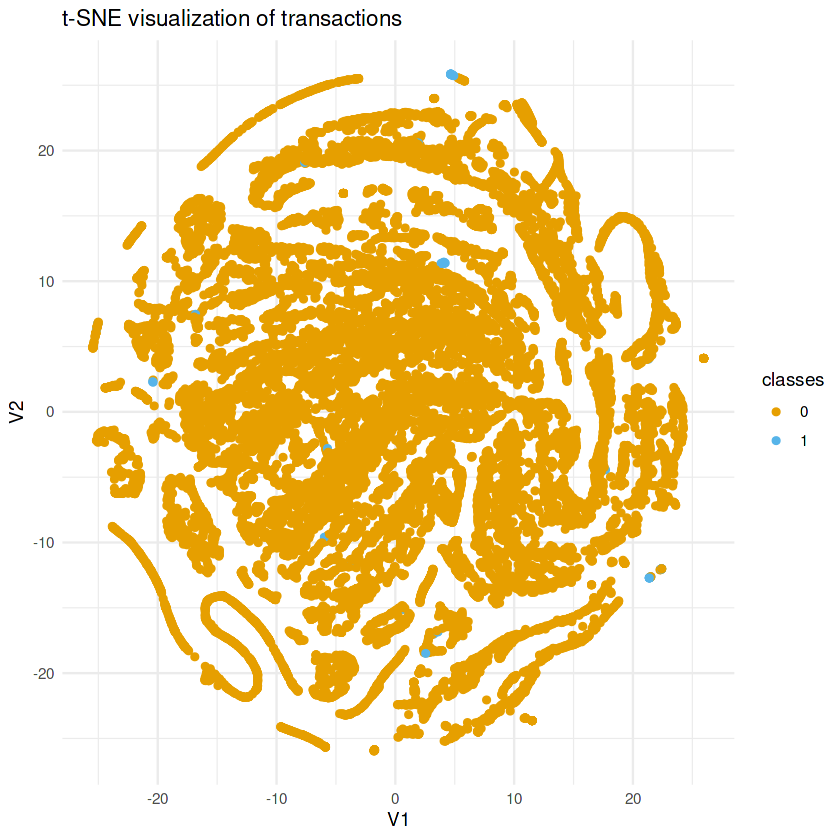

In [ ]:
# t-SNE visualization
tsne_data <- 1:as.integer(0.1 * nrow(dataset))
tsne <- Rtsne(dataset[tsne_data, -c(1, 31)], perplexity = 20, theta = 0.5, pca = FALSE, verbose = FALSE, max_iter = 500, check_duplicates = FALSE)
classes <- as.factor(dataset$Class[tsne_data])
tsne_matrix <- as.data.frame(tsne$Y)
ggplot(tsne_matrix, aes(x = V1, y = V2)) +
  geom_point(aes(color = classes)) +
  theme_minimal() +
  ggtitle("t-SNE visualization of transactions") +
  scale_color_manual(values = c("#E69F00", "#56B4E9"))

In [ ]:
# Scaling the data using standardization and remove the first column (time) from the dataset
dataset$Amount <- scale(dataset$Amount)
new_data <- dataset[, -c(1)]
head(new_data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,0.09079417,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,0.24496383,0
1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,-0.16697441,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,-0.34247394,0
-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,0.20764287,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,1.16068389,0
-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,-0.05495192,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,0.14053401,0
-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,0.75307443,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,-0.07340321,0
-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,-0.37140720,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,-0.33855582,0


In [ ]:
# Convert Class to factor and rename levels
new_data$Class <- as.factor(new_data$Class)
levels(new_data$Class) <- c("Not Fraud", "Fraud")

In [ ]:
# Split the data into training set and test set
set.seed(101)
split <- sample.split(new_data$Class, SplitRatio = 0.8)
train_data <- subset(new_data, split == TRUE)
test_data <- subset(new_data, split == FALSE)

Warning message:
“`stat(count)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


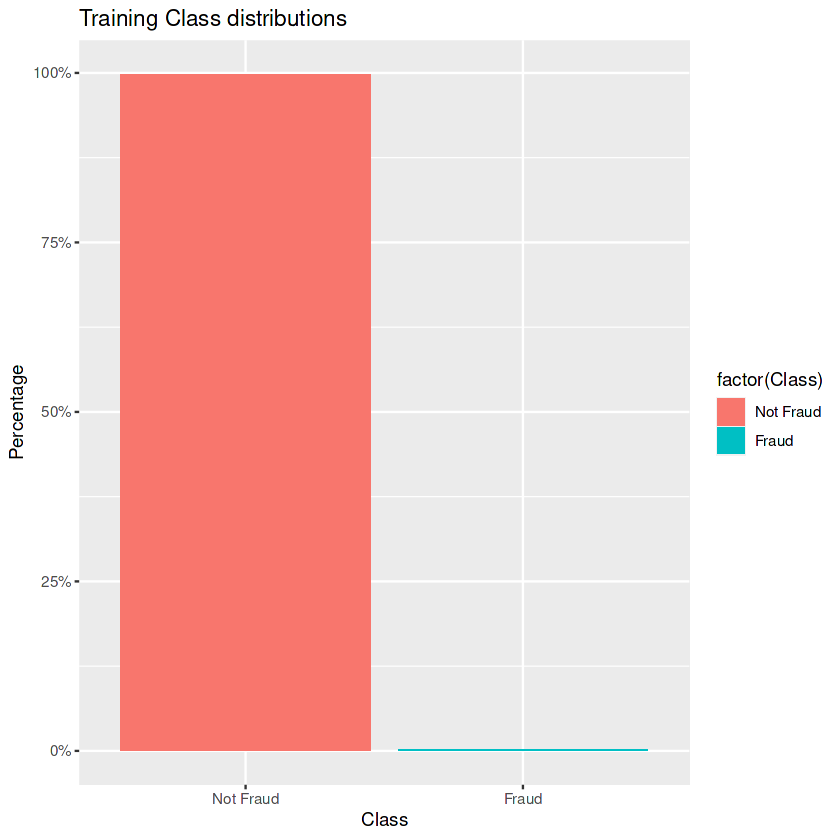

In [ ]:
# Visualize the training data
train_data %>%
  ggplot(aes(x = factor(Class), y = prop.table(stat(count)), fill = factor(Class))) +
  geom_bar(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(x = 'Class', y = 'Percentage', title = 'Training Class distributions') +
  theme_grey()


In [ ]:
# Address class imbalance using ROSE
set.seed(9560)
rose_train_data <- ROSE(Class ~ ., data = train_data)$data
table(rose_train_data$Class)


Not Fraud     Fraud 
   114081    113765 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = rose_train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.1521  -0.4101  -0.0910   0.0312   4.4617  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.369801   0.010954 -216.339  < 2e-16 ***
V1          -0.051171   0.002427  -21.086  < 2e-16 ***
V2           0.069306   0.003404   20.360  < 2e-16 ***
V3          -0.074309   0.002521  -29.473  < 2e-16 ***
V4           0.476417   0.004329  110.047  < 2e-16 ***
V5           0.024093   0.003080    7.821 5.23e-15 ***
V6          -0.172857   0.005369  -32.197  < 2e-16 ***
V7          -0.053610   0.002615  -20.501  < 2e-16 ***
V8          -0.063017   0.002526  -24.950  < 2e-16 ***
V9          -0.107009   0.005367  -19.938  < 2e-16 ***
V10         -0.171237   0.003635  -47.113  < 2e-16 ***
V11          0.291093   0.005151   56.510  < 2e-16 ***
V12         -0.233691   0.003749  -62.333  < 2e-16 ***
V13         -0.182782   

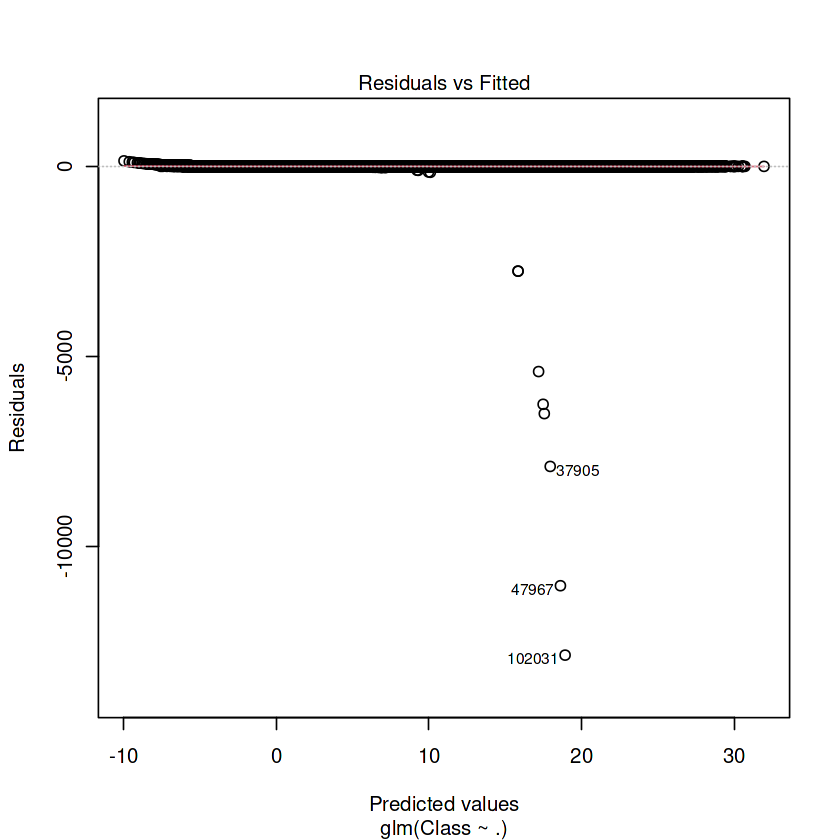

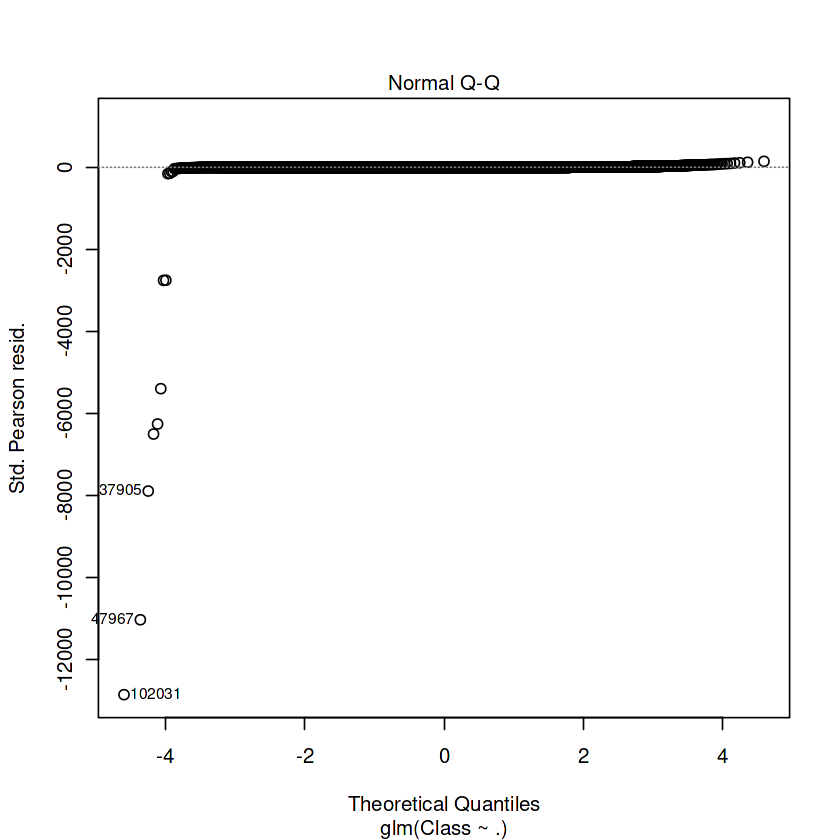

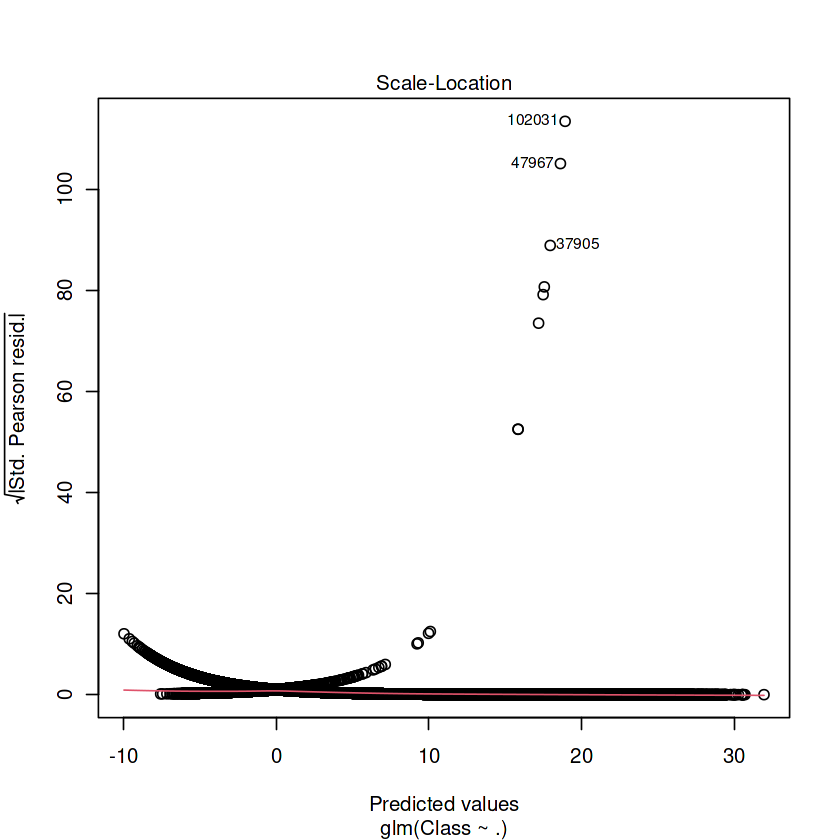

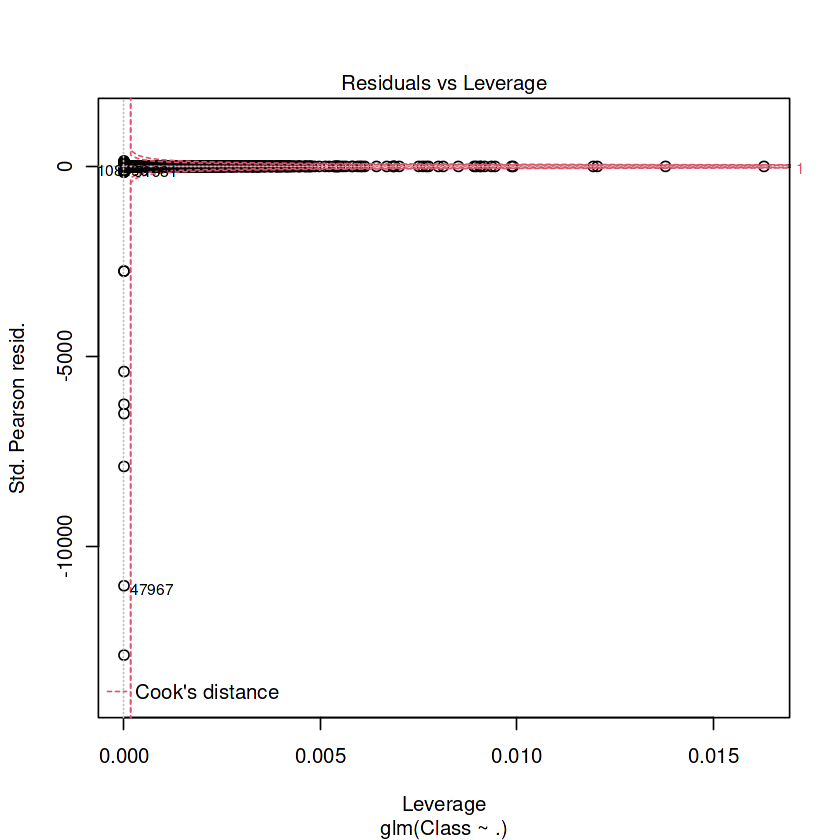

In [ ]:
# Fitting the logistic model
logistic_model <- glm(Class ~ ., data = rose_train_data, family = 'binomial')
summary(logistic_model)
plot(logistic_model)

Area under the curve (AUC): 0.977

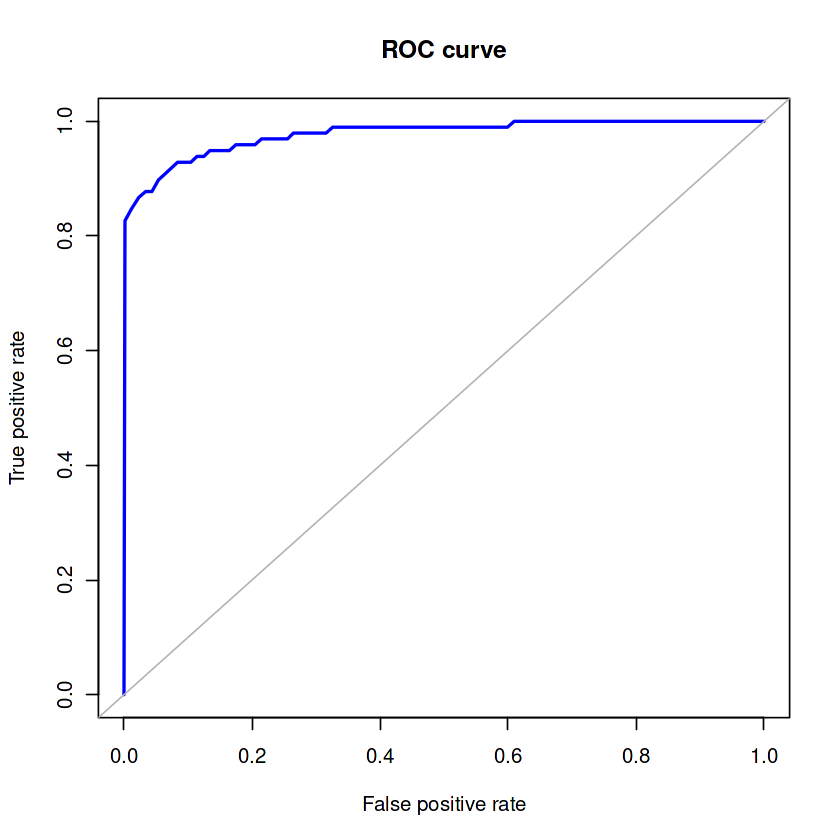

In [ ]:
# Predictions for logistic regression
logistic_predictions <- predict(logistic_model, test_data, type = 'response')
roc.curve(test_data$Class, logistic_predictions, plotit = TRUE, col = "blue")

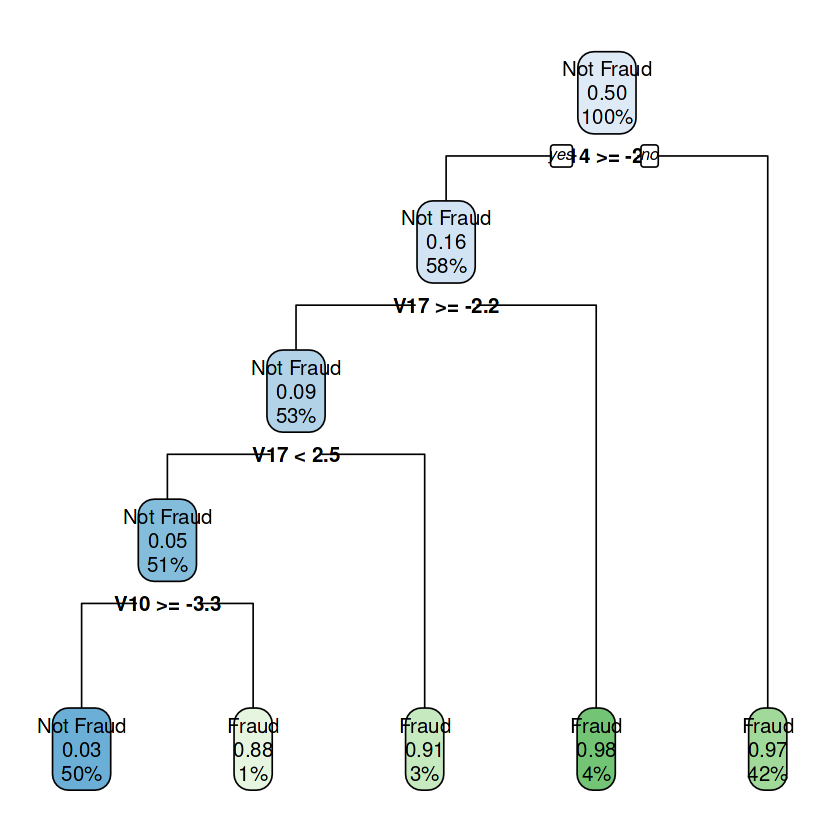

In [ ]:
# Decision tree model
decisionTree_model <- rpart(Class ~ . , data = rose_train_data, method = 'class')
predicted_val <- predict(decisionTree_model, rose_train_data, type = 'class')
probability <- predict(decisionTree_model, rose_train_data, type = 'prob')
rpart.plot(decisionTree_model)

In [ ]:
# Random forest model using Ranger
rf_fit <- ranger(Class ~ ., data = rose_train_data, num.trees = 1000, mtry = 13, min.node.size = 20, replace = FALSE)

Growing trees.. Progress: 2%. Estimated remaining time: 27 minutes, 11 seconds.
Growing trees.. Progress: 5%. Estimated remaining time: 24 minutes, 24 seconds.
Growing trees.. Progress: 7%. Estimated remaining time: 23 minutes, 9 seconds.
Growing trees.. Progress: 9%. Estimated remaining time: 22 minutes, 16 seconds.
Growing trees.. Progress: 12%. Estimated remaining time: 21 minutes, 40 seconds.
Growing trees.. Progress: 14%. Estimated remaining time: 21 minutes, 1 seconds.
Growing trees.. Progress: 16%. Estimated remaining time: 20 minutes, 28 seconds.
Growing trees.. Progress: 18%. Estimated remaining time: 20 minutes, 0 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 19 minutes, 29 seconds.
Growing trees.. Progress: 23%. Estimated remaining time: 18 minutes, 57 seconds.
Growing trees.. Progress: 25%. Estimated remaining time: 18 minutes, 23 seconds.
Growing trees.. Progress: 27%. Estimated remaining time: 17 minutes, 47 seconds.
Growing trees.. Progress: 29%. Esti

Area under the curve (AUC): 0.911

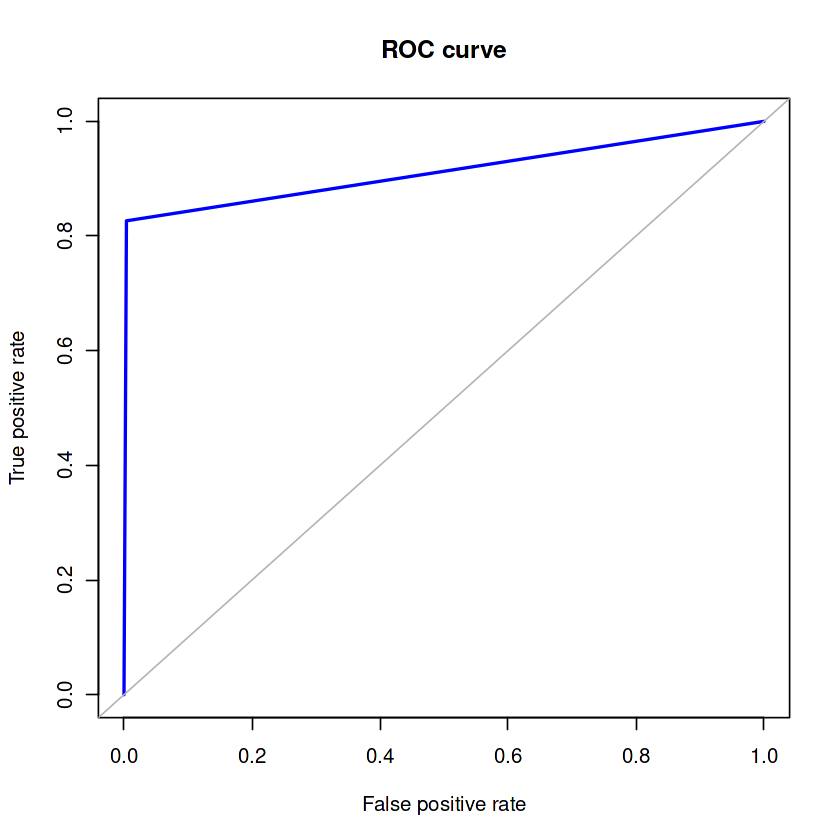

In [ ]:
# Predictions for random forest
rf_pred <- predict(rf_fit, data = test_data[,-30], predict.all = TRUE)
prob <- rf_pred$predictions
roc.curve(test_data$Class, prob[,2], plotit = TRUE, col = 'blue')

In [ ]:
# XGBoost model
labels <- as.numeric(rose_train_data$Class) - 1
xgb_fit <- xgboost(data = data.matrix(rose_train_data[, -ncol(rose_train_data)]),
                   label = labels,
                   eta = 0.1,
                   gamma = 0.1,
                   max_depth = 10,
                   nrounds = 300,
                   objective = "binary:logistic",
                   colsample_bytree = 0.6,
                   verbose = 0,
                   nthread = 7
)

Area under the curve (AUC): 0.949

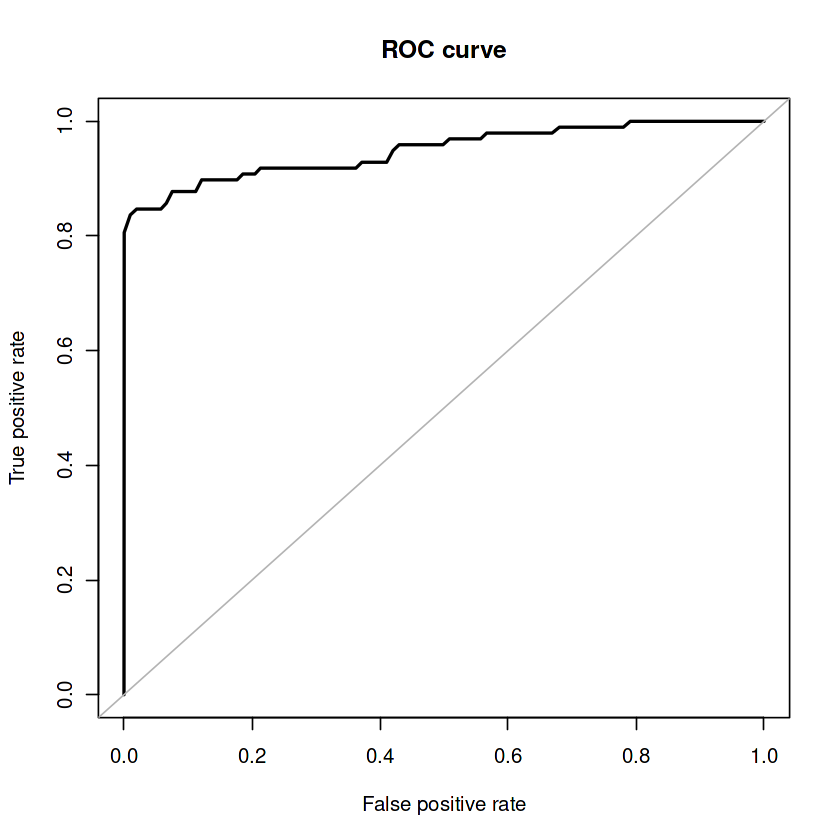

In [ ]:
# Predictions for XGBoost
xgb_pred <- predict(xgb_fit, data.matrix(test_data[,-30]))
roc.curve(test_data$Class, xgb_pred, plotit = TRUE)

In [ ]:
# Compute feature importance matrix for XGBoost
names <- dimnames(data.matrix(rose_train_data[,-30]))[[2]]
importance_matrix <- xgb.importance(names, model = xgb_fit)

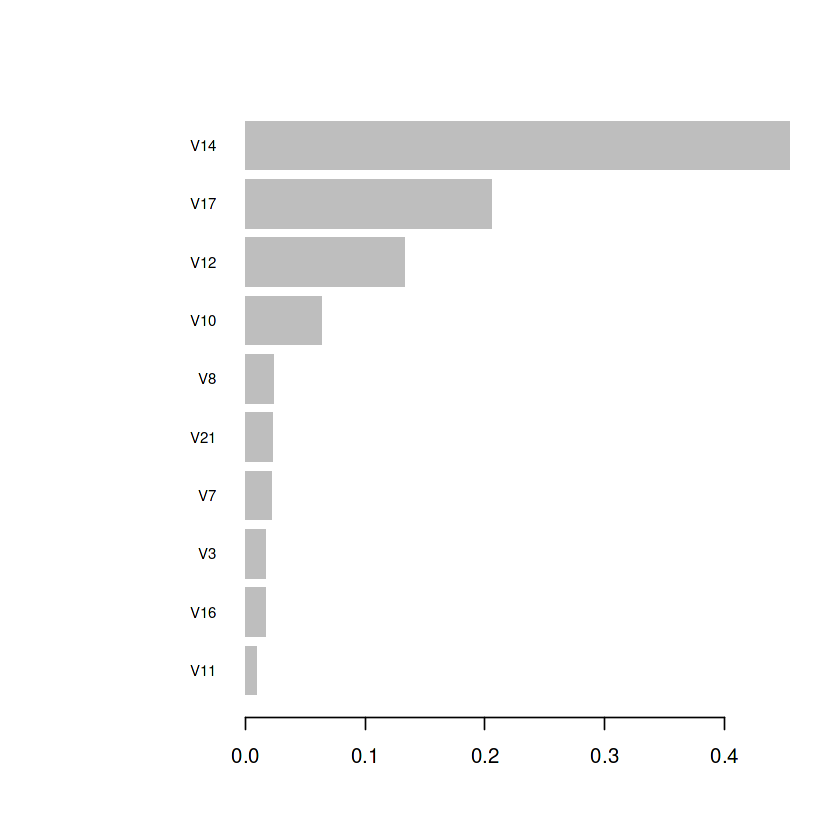

In [ ]:
# Nice graph for feature importance
xgb.plot.importance(importance_matrix[1:10,])